In [1]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
from shortcut_analysis import *
from explore_analysis import *

from tqdm import tqdm
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from pathlib import Path

pplt.rc.update({'font.size': 10})

In [85]:
len(chks)

36

In [92]:
chk_sched[25] * 64 * 100

2688000

In [99]:
def combine_wsns(wsns_res, chk=0):
    '''
    Combine the ws/ns episodes from our 100 episode trial experiments
    chk: the index of chk from chk_sched. 
        For example, chk=25 will be checkpoint 420 or 2.7e6 timesteps after
        shifted start of training
    '''
    chks = list(wsns_res['ws'].keys())
    if chk >= len(chks):
        return False

    chk = chks[chk]
    ws_res, ns_res = wsns_res['ws'][chk], wsns_res['ns'][chk]
    ws_activ = [a['shared_activations'][1] for a in ws_res['activs']]
    ns_activ = [a['shared_activations'][1] for a in ns_res['activs']]
    ws_pos, ns_pos = ws_res['ep_pos'], ns_res['ep_pos']
    ws_lens, ns_lens = get_ep_lens(ws_pos), get_ep_lens(ns_pos)
    ws_used, ns_used = [check_shortcut_usage(p) for p in ws_res['ep_pos']], [False]*50

    activ = torch.vstack(ws_activ+ns_activ)
    ep_pos = ws_pos + ns_pos
    used = ws_used + ns_used
    pos = np.vstack(ep_pos)

    ws_lens, ns_lens = get_ep_lens(ws_pos), get_ep_lens(ns_pos)
    lens = ws_lens + ns_lens

    return {
        'ep_activ': ws_activ+ns_activ,
        'activ': activ,
        'ep_pos': ep_pos,
        'pos': pos,
        'used': used,
        'lens': lens,
        'chk': chk
    }



def add_activ2d_to_wsns(wsns_res, chk=0):
    '''
    Add activ2d to a ws/ns episodes save
    '''
    comb = combine_wsns(wsns_res, chk)
    if not comb:
        return None
    
    activ = comb['activ']
    lens = comb['lens']
    save_chk = comb['chk']
    
    umap = UMAP(min_dist=0.35)
    activ2d = umap.fit_transform(np.vstack(activ)).astype('float16')
    
    ep_activ2d = ep_split_res(activ2d, lens)
    ws_activ2d, ns_activ2d = ep_activ2d[:50], ep_activ2d[50:]
    
    if 'activ2d' not in wsns_res:
        wsns_res['activ2d'] = {}
        
    wsns_res['activ2d'][save_chk] = activ2d
    wsns_res['ws'][save_chk]['activ2d'] = ws_activ2d
    wsns_res['ns'][save_chk]['activ2d'] = ns_activ2d
    
    return True
    

In [ ]:
prefixes = ['', '0.2_']
aux_tasks = ['catfacewall', 'catquad', 'catshort', 'catwall01', 'wall01']
trials = range(10)
folder = Path('data/shortcut/sc_aux_copied')

for p, aux, t in itertools.product(prefixes, aux_tasks, trials):
    file = f'{p}{aux}_{t}'
    if not file in [i.name for i in folder.iterdir()]:
        continue
    
    

In [86]:
folder = Path('data/shortcut/wc1.5_policy')
all_res = pickle.load(open(folder/'0.8_4', 'rb'))

chks = list(all_res['ws'].keys())

ws_res, ns_res = all_res['ws'][chk], all_res['ns'][chk]
ws_activ = [a['shared_activations'][1] for a in ws_res['activs']]
ns_activ = [a['shared_activations'][1] for a in ns_res['activs']]
# ws_pos, ns_pos = np.vstack(ws_res['ep_pos']), np.vstack(ns_res['ep_pos'])
ws_pos, ns_pos = ws_res['ep_pos'], ns_res['ep_pos']
ws_lens, ns_lens = get_ep_lens(ws_pos), get_ep_lens(ns_pos)
ws_used, ns_used = [check_shortcut_usage(p) for p in ws_res['ep_pos']], [False]*50

activ = torch.vstack(ws_activ+ns_activ)
ep_pos = ws_pos + ns_pos
used = ws_used + ns_used
pos = np.vstack(ep_pos)

ws_lens, ns_lens = get_ep_lens(ws_pos), get_ep_lens(ns_pos)
lens = ws_lens + ns_lens

umap = UMAP(min_dist=0.35)
activ2d = umap.fit_transform(np.vstack(activ)).astype('float16')

ep_activ2d = ep_split_res(activ2d, lens)
ws_activ2d, ns_activ2d = ep_activ2d[:50], ep_activ2d[50:]
all_res['ws'][chk]['activ2d'] = ws_activ2d
all_res['ns'][chk]['activ2d'] = ns_activ2d

In [87]:
all_res['ws'][chk].keys()

dict_keys(['activs', 'actions', 'ep_pos', 'ep_angle', 'vis', 'shortcut', 'activ2d'])

In [88]:
labels, _ = decompose_shortcut_trajectories(ep_pos=ep_pos, ep_shortcut_used=used)

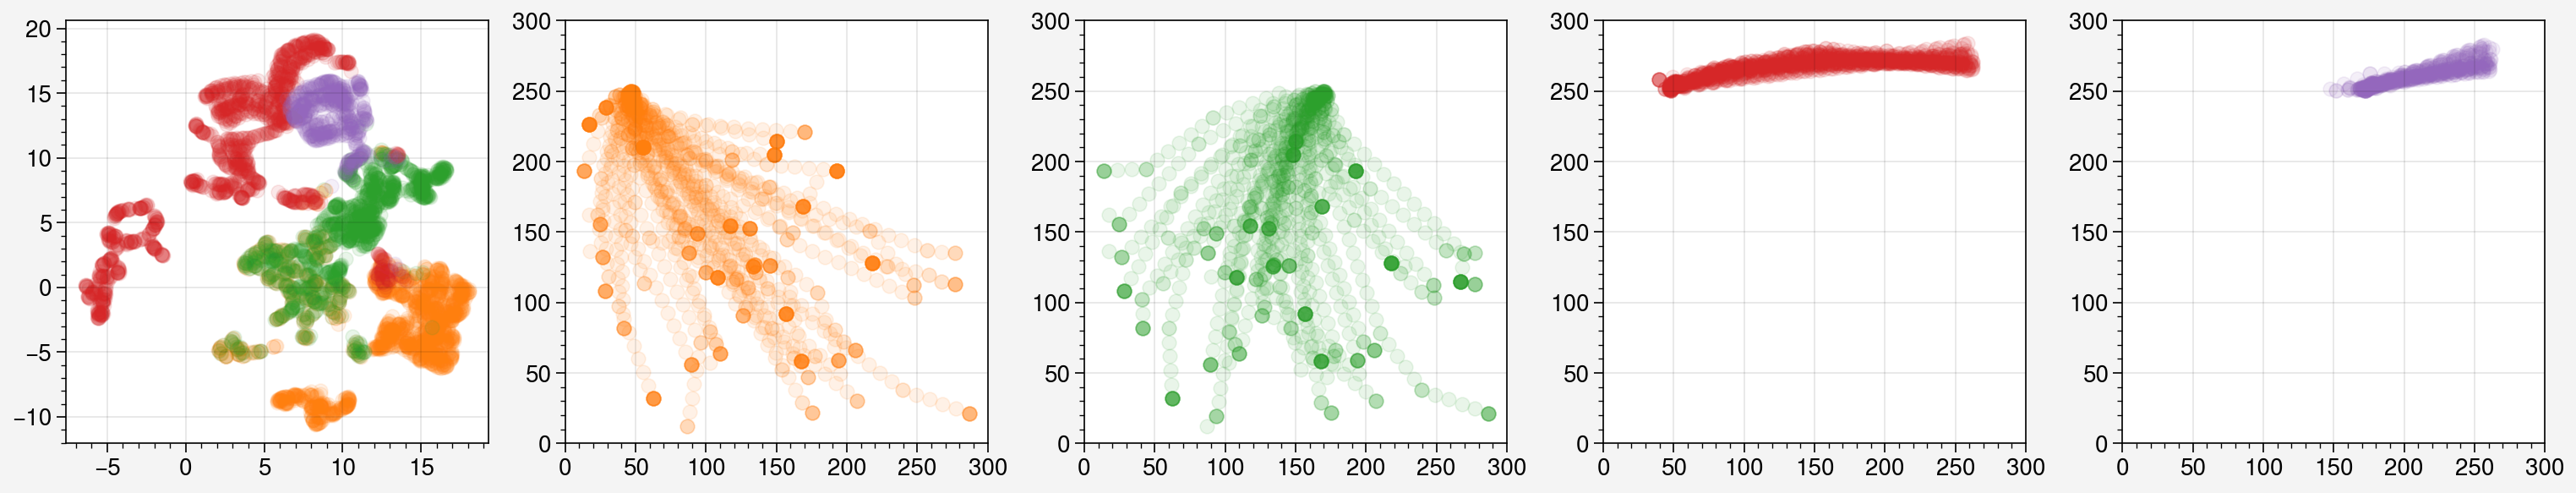

In [89]:
colored_activ2d_plot(activ2d, labels, pos)

In [73]:
ws_lens, ns_lens = get_ep_lens(ws_pos), get_ep_lens(ns_pos)
lens = ws_lens + ns_lens

umap = UMAP(min_dist=0.35)
activ2d = umap.fit_transform(np.vstack(activ)).astype('float16')

ep_activ2d = ep_split_res(activ2d, lens)
ws_activ2d, ns_activ2d = ep_activ2d[:50], ep_activ2d[50:]

In [58]:
pickle.dump(umap, open('data/test',  'wb'))

In [ ]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

for p, t in tqdm(itertools.product(probs, trials), total=len(probs)*10):
    # if p == 0.0 and t == 0: continue
    
    file = f'{p}_{t}'
    if not file in [i.name for i in folder.iterdir()]:
        continue
        
    all_res = pickle.load(open(folder/file, 'rb'))
    for i in range(len(chk_sched)):
        add_activ2d_to_wsns(all_res, i)
    pickle.dump(all_res, open(folder/file, 'wb'))

 61%|██████████████████████████████████████████████▌                             | 49/80 [11:50:24<5:23:51, 626.82s/it]

In [ ]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)
folder = Path('data/shortcut/wc1.5_copied')

for p, t in tqdm(itertools.product(probs, trials), total=len(probs)*10):
    file = f'{p}_{t}'
    if not file in [i.name for i in folder.iterdir()]:
        continue
        
    all_res = pickle.load(open(folder/file, 'rb'))
    for i in range(len(chk_sched)):
        add_activ2d_to_wsns(all_res, i)
    pickle.dump(all_res, open(folder/file, 'wb'))